<a href="https://colab.research.google.com/github/NicolasSpettel/lab-lora-tuning-peft/blob/main/lab-lora-tuning-peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

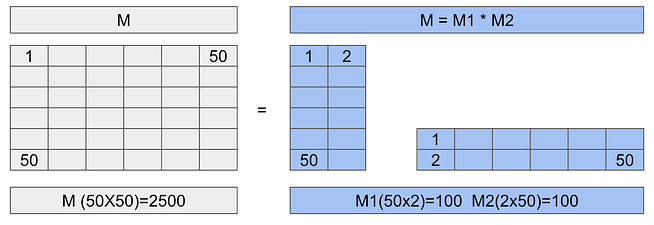

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
#!pip install -q peft==0.8.2
#!pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

In [2]:
#pip install --upgrade fsspec==2025.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.10.0
    Uninstalling fsspec-2023.10.0:
      Successfully uninstalled fsspec-2023.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.16.1 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.


From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import peft
from peft import LoraConfig, get_peft_model, PeftModel
import os
import transformers
from transformers import TrainingArguments, Trainer

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [4]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [5]:
#Inference original model
input_sentences = tokenizer("You are a travelling Salesman in the 1960s that is selling vacuum cleaner.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You have to be able for you self and your company, so it will not take much time if you’re going on vacation or traveling with family members.\nIf it’s an issue of getting rid off all those dusty clothes from inside out then this can make']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [6]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Using the latest cached version of the dataset since fka/awesome-chatgpt-prompts couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/fka___awesome-chatgpt-prompts/default/0.0.0/68ba7694e23014788dcc8ab5afe613824f45a05c (last modified on Fri Aug 22 12:13:41 2025).


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [7]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [8]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [9]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [10]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [11]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    #use_cpu=True
    report_to = "none"
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [12]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

Step,Training Loss


TrainOutput(global_step=14, training_loss=4.836050306047712, metrics={'train_runtime': 11.4823, 'train_samples_per_second': 8.709, 'train_steps_per_second': 1.219, 'total_flos': 21871163621376.0, 'train_loss': 4.836050306047712, 'epoch': 2.0})

In [13]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [14]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [18]:
device = loaded_model.device
input_sentences = tokenizer("You are a travelling Salesman in the 1960s that is selling vacuum cleaner.", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You I act as an acting for you, and then it will have heI wantIt ItHe HeIl IlMyFirstEleIdAndThenIfThisIsHereInThereI\'llI\'mI\'veJustI"ai""IJII""Myui"']


The result is horrendous, we need to fine tune a lot here it seems:
* **Pretrained Model:** *'You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You have to be able for you self and your company, so it will not take much time if you’re going on vacation or traveling with family members.\nIf it’s an issue of getting rid off all those dusty clothes from inside out then this can make'

* **Fine-Tuned Model:** 'You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You I act as an acting for you, and then it will have heI wantIt ItHe HeIl IlMyFirstEleIdAndThenIfThisIsHereInThereI\'llI\'mI\'veJustI"ai""IJII""Myui"

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [19]:
# Hyperparameters for easy tuning
LORA_R = 8  # Rank of adaptation matrices (higher = more parameters to train)
LORA_ALPHA = 16  # Scaling factor for LoRA weights
LORA_DROPOUT = 0.1  # Dropout rate to prevent overfitting
LEARNING_RATE = 1e-4  # Learning rate for training
NUM_EPOCHS = 3  # Number of training epochs
BATCH_SIZE = 4  # Training batch size (set to None for auto_find_batch_size)
MAX_NEW_TOKENS = 100  # Maximum tokens to generate during inference
DATASET_SAMPLE_SIZE = 100  # Number of samples to use from dataset

model_name = "bigscience/bloom-560m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs


# Load and prepare the dataset
dataset = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(DATASET_SAMPLE_SIZE))
train_sample = train_sample.remove_columns('act')

# Configure LoRA parameters for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=["query_key_value"],
    lora_dropout=LORA_DROPOUT,
    bias="lora_only",
    task_type="CAUSAL_LM"
)

# Apply LoRA configuration to the foundation model
peft_model = get_peft_model(foundation_model, lora_config)

# Set up training directory and output path
working_dir = './'
output_directory = os.path.join(working_dir, "peft_lab_outputs")

# Configure training arguments and hyperparameters
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True if BATCH_SIZE is None else False,
    per_device_train_batch_size=BATCH_SIZE if BATCH_SIZE is not None else None,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    report_to="none"
)

# Initialize trainer with model, arguments, and data collator
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Execute the fine-tuning process
trainer.train()

# Save the trained LoRA adapter weights
peft_model_path = os.path.join(output_directory, f"lora_model")
trainer.model.save_pretrained(peft_model_path)

# Load the fine-tuned model for inference
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

# Test the fine-tuned model with a sample prompt
device = loaded_model.device
input_sentences = tokenizer("You are a travelling Salesman in the 1960s that is selling vacuum cleaner.", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=MAX_NEW_TOKENS)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Using the latest cached version of the dataset since fka/awesome-chatgpt-prompts couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/fka___awesome-chatgpt-prompts/default/0.0.0/68ba7694e23014788dcc8ab5afe613824f45a05c (last modified on Fri Aug 22 12:20:55 2025).


Step,Training Loss


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You have to find out how many people will buy your product and what they want from you.\nI am looking for an answer on this question, I need help with finding answers about "how much does it cost"? Please let me know if there was any other way of solving my problem or just give some advice as well! Thankyou!\nHi I\'m interested In buying new car but i don\'t really understand where can get info regarding price etc.. please advise\nHello sir ,i\'m searching information related']


**CHANGES**
# Hyperparameters for easy tuning
* LORA_R:  4 -> **8**
* LORA_ALPHA:  1 -> **16**
* LORA_DROPOUT:  0.05 -> **0.1**
* LEARNING_RATE:  3e-2 -> **1e-4**
* NUM_EPOCHS:  2 -> **3**
* *NEW* per_device_train_batch_size = BATCH_SIZE = **4**
* MAX_NEW_TOKENS:  50 -> **100**
* DATASET_SAMPLE_SIZE 50 -> **100**
* Time : 33s

New output: 'You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You have to find out how many people will buy your product and what they want from you.\nI am looking for an answer on this question, I need help with finding answers about "how much does it cost"? Please let me know if there was any other way of solving my problem or just give some advice as well! Thankyou!\nHi I\'m interested In buying new car but i don\'t really understand where can get info regarding price etc.. please advise\nHello sir ,i\'m searching information related'

In [20]:
# Hyperparameters for easy tuning
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LEARNING_RATE = 5e-5
NUM_EPOCHS = 5
BATCH_SIZE = 2
MAX_NEW_TOKENS = 100
DATASET_SAMPLE_SIZE = 200

model_name = "bigscience/bloom-560m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs


# Load and prepare the dataset
dataset = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(DATASET_SAMPLE_SIZE))
train_sample = train_sample.remove_columns('act')

# Configure LoRA parameters for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=["query_key_value"],
    lora_dropout=LORA_DROPOUT,
    bias="lora_only",
    task_type="CAUSAL_LM"
)

# Apply LoRA configuration to the foundation model
peft_model = get_peft_model(foundation_model, lora_config)

# Set up training directory and output path
working_dir = './'
output_directory = os.path.join(working_dir, "peft_lab_outputs")

# Configure training arguments and hyperparameters
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True if BATCH_SIZE is None else False,
    per_device_train_batch_size=BATCH_SIZE if BATCH_SIZE is not None else None,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    report_to="none"
)

# Initialize trainer with model, arguments, and data collator
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Execute the fine-tuning process
trainer.train()

# Save the trained LoRA adapter weights
peft_model_path = os.path.join(output_directory, f"lora_model")
trainer.model.save_pretrained(peft_model_path)

# Load the fine-tuned model for inference
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

# Test the fine-tuned model with a sample prompt
device = loaded_model.device
input_sentences = tokenizer("You are a travelling Salesman in the 1960s that is selling vacuum cleaner.", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=MAX_NEW_TOKENS)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Using the latest cached version of the dataset since fka/awesome-chatgpt-prompts couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/fka___awesome-chatgpt-prompts/default/0.0.0/68ba7694e23014788dcc8ab5afe613824f45a05c (last modified on Fri Aug 22 12:20:55 2025).


Step,Training Loss
500,2.821800


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You have to provide information about your product and its features, such as power consumption or cleaning efficiency etc., so you can get more customers interested when they visit website for buying products from this company.\nI am an experienced salesperson who has been working with companies since 2009 providing them advice on how best ways of increasing their revenues by using digital marketing strategies like social media advertising campaigns which I believe will help increase revenue significantly through increased awareness amongst potential clients regarding my services/products\nMy name Is Naveen']


**CHANGES**
# Hyperparameters for easy tuning
* LORA_R: 8 → 16
* LORA_ALPHA: 16 → 32
* LORA_DROPOUT: 0.1 → 0.05
* LEARNING_RATE: 1e-4 → 5e-5
* NUM_EPOCHS: 3 → 5
* BATCH_SIZE: 4 → 2
* DATASET_SAMPLE_SIZE: 100 → 200
* Time: 2:00

New output: You are a travelling Salesman in the 1960s that is selling vacuum cleaner. You have to provide information about your product and its features, such as power consumption or cleaning efficiency etc., so you can get more customers interested when they visit website for buying products from this company.\nI am an experienced salesperson who has been working with companies since 2009 providing them advice on how best ways of increasing their revenues by using digital marketing strategies like social media advertising campaigns which I believe will help increase revenue significantly through increased awareness amongst potential clients regarding my services/products\nMy name Is Naveen

With improved hyper parameters we can see improvements in the text, but we are still not close to a really good prompt. Maybe a different model?

In [21]:
# Hyperparameters for easy tuning
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LEARNING_RATE = 5e-5
NUM_EPOCHS = 5
BATCH_SIZE = 2
MAX_NEW_TOKENS = 100
DATASET_SAMPLE_SIZE = 200

#model_name = "bigscience/bloom-560m"
model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs


# Load and prepare the dataset
dataset = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(DATASET_SAMPLE_SIZE))
train_sample = train_sample.remove_columns('act')

# Configure LoRA parameters for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=["query_key_value"],
    lora_dropout=LORA_DROPOUT,
    bias="lora_only",
    task_type="CAUSAL_LM"
)

# Apply LoRA configuration to the foundation model
peft_model = get_peft_model(foundation_model, lora_config)

# Set up training directory and output path
working_dir = './'
output_directory = os.path.join(working_dir, "peft_lab_outputs")

# Configure training arguments and hyperparameters
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True if BATCH_SIZE is None else False,
    per_device_train_batch_size=BATCH_SIZE if BATCH_SIZE is not None else None,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    report_to="none"
)

# Initialize trainer with model, arguments, and data collator
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Execute the fine-tuning process
trainer.train()

# Save the trained LoRA adapter weights
peft_model_path = os.path.join(output_directory, f"lora_model")
trainer.model.save_pretrained(peft_model_path)

# Load the fine-tuned model for inference
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

# Test the fine-tuned model with a sample prompt
device = loaded_model.device
input_sentences = tokenizer("You are a travelling Salesman in the 1960s that is selling vacuum cleaner.", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=MAX_NEW_TOKENS)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

Using the latest cached version of the dataset since fka/awesome-chatgpt-prompts couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/fka___awesome-chatgpt-prompts/default/0.0.0/68ba7694e23014788dcc8ab5afe613824f45a05c (last modified on Fri Aug 22 12:20:55 2025).


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Step,Training Loss
500,2.595700


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['You are a travelling Salesman in the 1960s that is selling vacuum cleaner. Your task: You should convince people to buy your product by showing them how it works and what benefits they will get from using this device, such as saving time or money on cleaning tasks.\nYour first move is: I have an empty bottle of water with some salt inside which you can fill up when needed for example if there’s no one around then just add more salt;\nI also need something else like my car keys so i put these into it; etc; but don’t forget about any other useful things']


Time: 3:18

New output: You are a travelling Salesman in the 1960s that is selling vacuum cleaner. Your task: You should convince people to buy your product by showing them how it works and what benefits they will get from using this device, such as saving time or money on cleaning tasks.\nYour first move is: I have an empty bottle of water with some salt inside which you can fill up when needed for example if there’s no one around then just add more salt;\nI also need something else like my car keys so i put these into it; etc; but don’t forget about any other useful things

The bigger model with fine tuned parameters starts off really good, but quickly loses focus it seems

In [29]:
import torch
torch.cuda.empty_cache()

In [2]:
# Hyperparameters for easy tuning
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LEARNING_RATE = 2e-5
NUM_EPOCHS = 8
BATCH_SIZE = 1
MAX_NEW_TOKENS = 100
DATASET_SAMPLE_SIZE = 100
GRADIENT_ACCUMULATION_STEPS = 4

#model_name = "bigscience/bloom-560m"
model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.6,  # Lower temperature for more focused output
        top_p=0.85,       # Nucleus sampling to limit token choices
        top_k=40,         # Additional filtering for coherence
        repetition_penalty=1.3,  # Strong penalty against repetition
        no_repeat_ngram_size=3,  # Prevent 3-gram repetition
        early_stopping=True,     # Stop at natural ending points
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

# Load and prepare the dataset
dataset = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(DATASET_SAMPLE_SIZE))
train_sample = train_sample.remove_columns('act')

# Configure LoRA parameters for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=["query_key_value"],
    lora_dropout=LORA_DROPOUT,
    bias="lora_only",
    task_type="CAUSAL_LM"
)

# Apply LoRA configuration to the foundation model
peft_model = get_peft_model(foundation_model, lora_config)

# Set up training directory and output path
working_dir = './'
output_directory = os.path.join(working_dir, "peft_lab_outputs")

# Configure training arguments and hyperparameters
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True if BATCH_SIZE is None else False,
    per_device_train_batch_size=BATCH_SIZE if BATCH_SIZE is not None else None,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    dataloader_num_workers=0,
    remove_unused_columns=True,
    report_to="none"
)

# Initialize trainer with model, arguments, and data collator
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Execute the fine-tuning process
trainer.train()

# Save the trained LoRA adapter weights
peft_model_path = os.path.join(output_directory, f"lora_model")
trainer.model.save_pretrained(peft_model_path)

# Load the fine-tuned model for inference
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

# Test the fine-tuned model with a sample prompt
device = loaded_model.device
input_sentences = tokenizer("As a 1960s vacuum cleaner salesman, I will demonstrate these key benefits:", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=MAX_NEW_TOKENS)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Using the latest cached version of the dataset since fka/awesome-chatgpt-prompts couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/fka___awesome-chatgpt-prompts/default/0.0.0/68ba7694e23014788dcc8ab5afe613824f45a05c (last modified on Fri Aug 22 12:49:22 2025).


Step,Training Loss


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


['As a 1960s vacuum cleaner salesman, I will demonstrate these key benefits:\n• A powerful suction motor helps remove dirt and debris from hard to reach areas • The large capacity of the pump allows you to clean deep into corners or crevices without having to use too much power. You can even place your hands in front of it while cleaning!']


Time: 2:24
* LORA_R:  16 (tried with 32 but ran out of RAM)        
* NUM_EPOCHS:  5 -> 8       
* LEARNING_RATE:  5e-5 -> 2e-5
* BATCH_SIZE: 2 -> 1 (Memory)
# modification to the get_outputs
* temperature=0.6
* top_p=0.85   
* top_k=40       
* repetition_penalty=1.3
* no_repeat_ngram_size=3
* early_stopping=True  
# modification to training_args (offload to cpu) (Memory)
* dataloader_num_workers = 0
* remove_unused_columns = True
* gradient_accumulation_steps = GRADIENT_ACCUMULATION_STEPS = 4
### different prompt:
You are a travelling Salesman in the 1960s that is selling vacuum cleaner.  
\- > As a 1960s vacuum cleaner salesman, I will demonstrate these key benefits:

New output: As a 1960s vacuum cleaner salesman, I will demonstrate these key benefits:\n• A powerful suction motor helps remove dirt and debris from hard to reach areas • The large capacity of the pump allows you to clean deep into corners or crevices without having to use too much power. You can even place your hands in front of it while cleaning!

Faster than the last attempt. LORA_R seems to be a big RAM user. Tuning the get_outputs and making other changes like the inital prompt resulted in a satisfying result.